In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import random
import calendar
from collections import defaultdict



from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import sys
sys.path.append('/data/gbmc/Rodeo_Submission/Competition_Functions') 
from Processing_Functions import process_forecast_date, process_seasonal_forecasts
from ML_Functions import Hydra_LSTM_Block, PinballLoss, SumPinballLoss, EarlyStopper, Model_Run
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly
# sys.path.append('/data/gbmc/Functions')
# from Efficiency_Functions import kling_gupta_efficiency, nash_sutcliffe_efficiency, KGE_Loss, NSE_Loss, Combined_Loss


sys.path.append('/data/gbmc/Rodeo_Submission/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column
import zipfile

# Data Preparation

## Lists of  basins and their quantiles

In [3]:
monthly_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',
    'fontenelle_reservoir_inflow', 'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow',
    'missouri_r_at_toston','owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',
    'ruedi_reservoir_inflow', 'skagit_ross_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin', 'sweetwater_r_nr_alcova',
    'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]


USGS_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',   
    'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow', 'merced_river_yosemite_at_pohono_bridge', 'missouri_r_at_toston',
    'owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',    'san_joaquin_river_millerton_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin',
    'sweetwater_r_nr_alcova', 'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]

basins = list(set(monthly_basins + USGS_basins))




In [4]:
## Historic Quantiles

quantiles = {
    'american_river_folsom_lake': {'10': 8.25890931, '50': 16.15167713, '90': 82.37816025},
    'animas_r_at_durango': {'10': 148.99123825, '50': 279.32773825, '90': 373.75623825},
    'boise_r_nr_boise': {'10': 775.93723825, '50': 1033.72273825, '90': 1478.30723825},
    'boysen_reservoir_inflow': {'10': 204.87023825, '50': 438.94273825, '90': 841.13573825},
    'colville_r_at_kettle_falls': {'10': 57.98373825, '50': 116.11323825, '90': 187.70223825},
    'detroit_lake_inflow': {'10': 6.86947102, '50': 13.29894623, '90': 30.09213939},
    'dillon_reservoir_inflow': {'10': 54.85473825, '50': 117.36573825, '90': 142.10273825},
    'fontenelle_reservoir_inflow': {'10': 286.99973825, '50': 420.65873825, '90': 828.92423825},
    'green_r_bl_howard_a_hanson_dam': {'10': 153.56873825, '50': 233.51123825, '90': 325.42373825},
    'hungry_horse_reservoir_inflow': {'10': 1437.45473825, '50': 1808.90123825, '90': 2254.66223825},
    'libby_reservoir_inflow': {'10': 3174.74673825, '50': 4428.96523825, '90': 5197.77823825},
    'missouri_r_at_toston': {'10': 851.17273825, '50': 1533.77423825, '90': 1883.71223825},
    'owyhee_r_bl_owyhee_dam': {'10': 103.47323825, '50': 160.73323825, '90': 499.06673825},
    'pecos_r_nr_pecos': {'10': 5.90123825, '50': 32.88623825, '90': 46.72873825},
    'pueblo_reservoir_inflow': {'10': 123.28373825, '50': 201.71073825, '90': 297.95423825},
    'ruedi_reservoir_inflow': {'10': 58.50173825, '50': 96.82073825, '90': 130.72273825},
    'skagit_ross_reservoir': {'10': 928.05423825, '50': 1117.87923825, '90': 1351.08423825},
    'snake_r_nr_heise': {'10': 1936.54673825, '50': 2373.29973825, '90': 3291.39823825},
    'stehekin_r_at_stehekin': {'10': 492.02873825, '50': 557.46223825, '90': 658.41673825},
    'sweetwater_r_nr_alcova': {'10': 14.10623825, '50': 30.35373825, '90': 74.62323825},
    'taylor_park_reservoir_inflow': {'10': 39.50873825, '50': 60.36173825, '90': 85.32823825},
    'virgin_r_at_virtin': {'10': 14.43423825, '50': 29.26573825, '90': 57.64473825},
    'weber_r_nr_oakley': {'10': 57.79523825, '50': 83.71873825, '90': 115.95923825},
    'yampa_r_nr_maybell': {'10': 420.85673825, '50': 802.86223825, '90': 1050.70273825},
    'san_joaquin_river_millerton_reservoir': {'10': 8.25890931, '50': 16.15167713, '90': 82.37816025},
    'merced_river_yosemite_at_pohono_bridge': {'10': 6.1894047, '50': 16.65905307, '90': 33.48977683},

}


## Downloading CSV Files

In [5]:
# Extract Data
selected_years = range(2000,2024,2)

era5_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/era5'
era5 = csv_dictionary(era5_folder, basins, years=selected_years)
era5 = add_day_of_year_column(era5)

flow_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_monthly_naturalized_flow'
flow = csv_dictionary(flow_folder, monthly_basins)
flow = filter_rows_by_year(flow, 1998)

climatology_file_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/climate_indices.csv'
climate_indices = pd.read_csv(climatology_file_path)
climate_indices['date'] = pd.to_datetime(climate_indices['date'])
climate_indices.set_index('date', inplace = True)
climate_indices.drop('Unnamed: 0', axis = 1, inplace = True)
climate_indices = climate_indices[~climate_indices.index.duplicated(keep='first')]

root_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/seasonal_forecasts'
seasonal_forecasts = read_nested_csvs(root_folder)

USGS_flow_folder = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows'
USGS_flow = csv_dictionary(USGS_flow_folder, USGS_basins)

Static_variables = pd.read_csv('/data/gbmc/Rodeo_Submission/Rodeo_Data/static_indices.csv', index_col= 'site_id')


## Transforming Flow Values

In [7]:
# Convert monthly flow values to daily flow estimates
daily_flow = {}

# Iterate through the dictionary and apply generate_daily_flow to each DataFrame
for key, df in flow.items():
    daily_flow[key] = generate_daily_flow(df, persistence_factor=0.7)

# Replacing monhtly data for normalised USGS when available
daily_flow = use_USGS_flow_data(daily_flow, USGS_flow)

In [8]:
# Introducing the data from San_jaoqin and Merced, normalised by the yearly flow given
path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/san_joaquin_river_millerton_reservoir.csv'
name = 'san_joaquin_river_millerton_reservoir'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/san_joaquin_river_millerton_reservoir.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/merced_river_yosemite_at_pohono_bridge.csv'
name = 'merced_river_yosemite_at_pohono_bridge'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/merced_river_yosemite_at_pohono_bridge.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/USGS_streamflows/detroit_lake_inflow.csv'
name = 'detroit_lake_inflow'
normalising_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/train_yearly/detroit_lake_inflow.csv'

USGS_to_daily_df_yearly(daily_flow, path, name, normalising_path)

In [9]:
# detroit and sweetwater train monthly are fucked
for key, df in daily_flow.items():
    length = len(df)
    nan_count = df['daily_flow'].isna().sum()
    
    # Check if the DataFrame is not empty
    if not df.empty:
        latest_date = df.index.max()
        print(f"{key}: Length = {length}, NaN count in 'daily_flow' = {nan_count}, Latest Date = {latest_date}")
    else:
        print(f"{key}: DataFrame is empty, Length = {length}, NaN count in 'daily_flow' = {nan_count}")

    

animas_r_at_durango: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
boise_r_nr_boise: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
boysen_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
colville_r_at_kettle_falls: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
detroit_lake_inflow: Length = 3828, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
dillon_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
fontenelle_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
green_r_bl_howard_a_hanson_dam: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
hungry_horse_reservoir_inflow: Length = 4282, NaN count in 'daily_flow' = 0, Latest Date = 2022-06-30 00:00:00
libby_reservoir_inflow: Length = 4282, NaN count i

## Scaling Variable Values

In [10]:
climate_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/climate_normalization_scaler.save'
climate_scaler = joblib.load(climate_scaler_filename) 
climate_indices = pd.DataFrame(climate_scaler.transform(climate_indices), columns=climate_indices.columns, index=climate_indices.index)

era5_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/era5_scaler.save'
era5_scaler = joblib.load(era5_scaler_filename) 
era5 = {key: pd.DataFrame(era5_scaler.transform(df), columns=df.columns, index=df.index) for key, df in era5.items()}

for basin, df in daily_flow.items(): 
    flow_scaler_filename = f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
    flow_scaler = joblib.load(flow_scaler_filename) 
    daily_flow[basin] = pd.DataFrame(flow_scaler.transform(df), columns=df.columns, index=df.index)

seasonal_scaler_filename = "/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/seasonal_scaler.save"
seasonal_scaler = joblib.load(seasonal_scaler_filename)
seasonal_forecasts = {key: pd.DataFrame(seasonal_scaler.transform(df), columns=df.columns, index=df.index ) for key, df in seasonal_forecasts.items()}

static_scaler_filename = '/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/static_scaler.save'
static_scaler = joblib.load(static_scaler_filename) 
Static_variables = pd.DataFrame(static_scaler.transform(Static_variables), columns=Static_variables.columns, index=Static_variables.index)



# Making Scalers


In [13]:
# Create scaled climatology for each day

climatological_flows = {}

for basin, df in daily_flow.items():
    # Extract day of year and flow values
    df['day_of_year'] = df.index.dayofyear

    grouped = df.groupby('day_of_year')['daily_flow'].quantile([0.1, 0.5, 0.9]).unstack(level=1)

    climatological_flows[basin] = pd.DataFrame({
        'day_of_year': grouped.index,
        '10th_percentile_flow': grouped[0.1],
        '50th_percentile_flow': grouped[0.5],
        '90th_percentile_flow': grouped[0.9]
    })
    
    climatological_flows[basin].set_index('day_of_year', inplace=True)

    # Drop the temporary 'day_of_year' column from the original dataframe
    df.drop(columns='day_of_year', inplace=True)

In [14]:
folder_path = '/data/gbmc/Rodeo_Submission/Rodeo_Data/climatological_flows'


for basin, df in climatological_flows.items():
    csv_name = f'{basin}_climatological_flows.csv'
    csv_path = os.path.join(folder_path, csv_name)
    df.to_csv(csv_path, index=False)

# Model Running

In [16]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim.lr_scheduler as lr_scheduler


import sys
sys.path.append('/data/gbmc/Rodeo_Submission/Performance_Evaluation') 
from Evaluation_Functions import test_performance_for_basin_and_season


In [20]:
# First build list of all possible forecast dates, can use any random basin to initialise this
basin = 'animas_r_at_durango' 
All_Dates = daily_flow[basin].index[
    ((daily_flow[basin].index.month < 6) | ((daily_flow[basin].index.month == 6) & (daily_flow[basin].index.day < 25))) &
    ((daily_flow[basin].index.year % 2 == 0) | ((daily_flow[basin].index.month > 10) | ((daily_flow[basin].index.month == 10) & (daily_flow[basin].index.day >= 1))))
]
All_Dates = All_Dates[All_Dates.year > 1998]


# Validation Year
Val_Dates = All_Dates[All_Dates.year == 2022]
All_Dates = All_Dates[All_Dates.year < 2022]


basin_to_remove = 'sweetwater_r_nr_alcova'

if basin_to_remove in basins:
    basins.remove(basin_to_remove)

# Loading Models


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Hydra_Body = torch.load('/data/gbmc/Rodeo_Submission/Models/09_02_Models/General_Body.pth')
Hydra_Body.to(device)

general_head_path = '/data/gbmc/Rodeo_Submission/Models/09_02_Models/General_Head.pth'
General_Hydra_Head = torch.load(general_head_path)
General_Hydra_Head.to(device)

model_heads = {}
for basin in basins:
    site_specific_head_path = f'/data/gbmc/Rodeo_Submission/Model/09_02_Models/{basin}_Head.pth'
    model_heads[f'{basin}'] = torch.load(site_specific_head_path)
    model_heads[f'{basin}'].to(device)


# Robby to Look: Plots from models


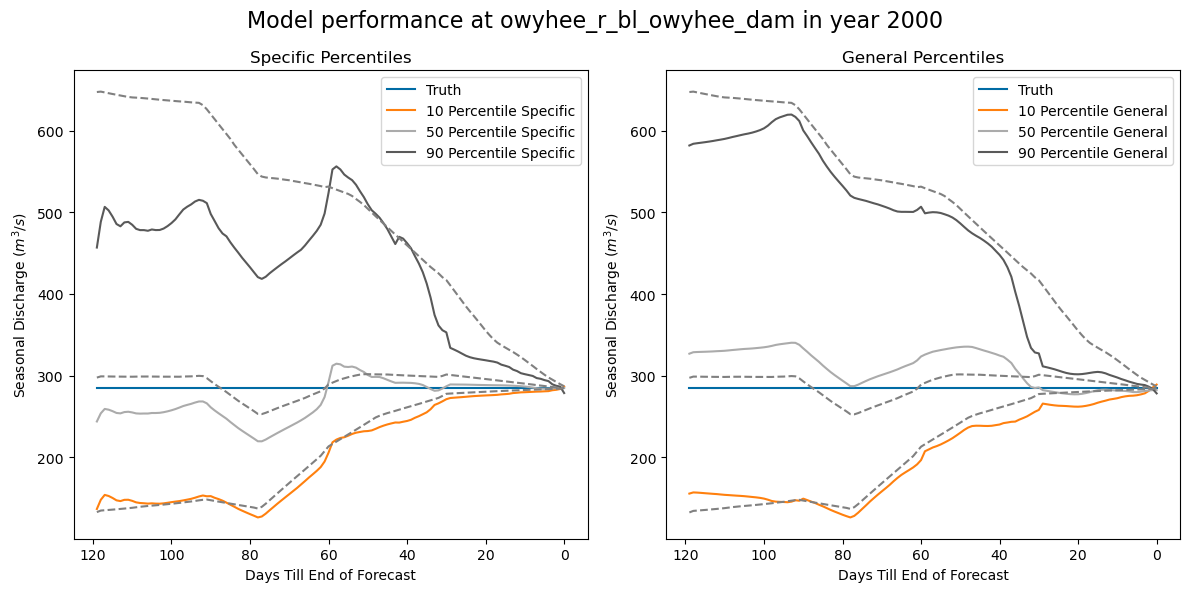

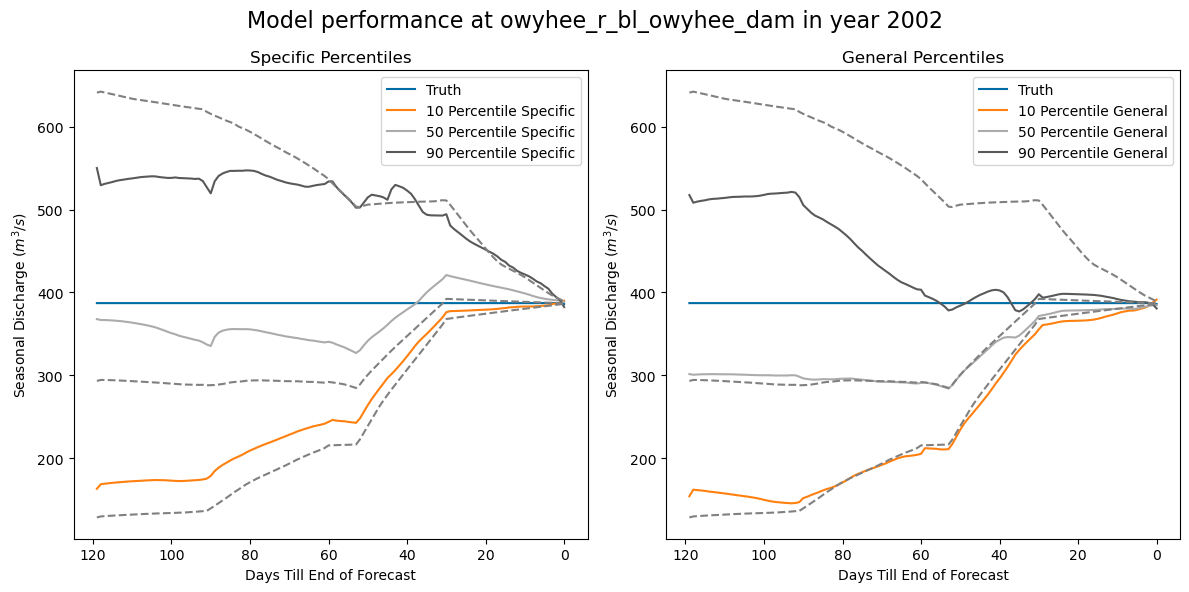

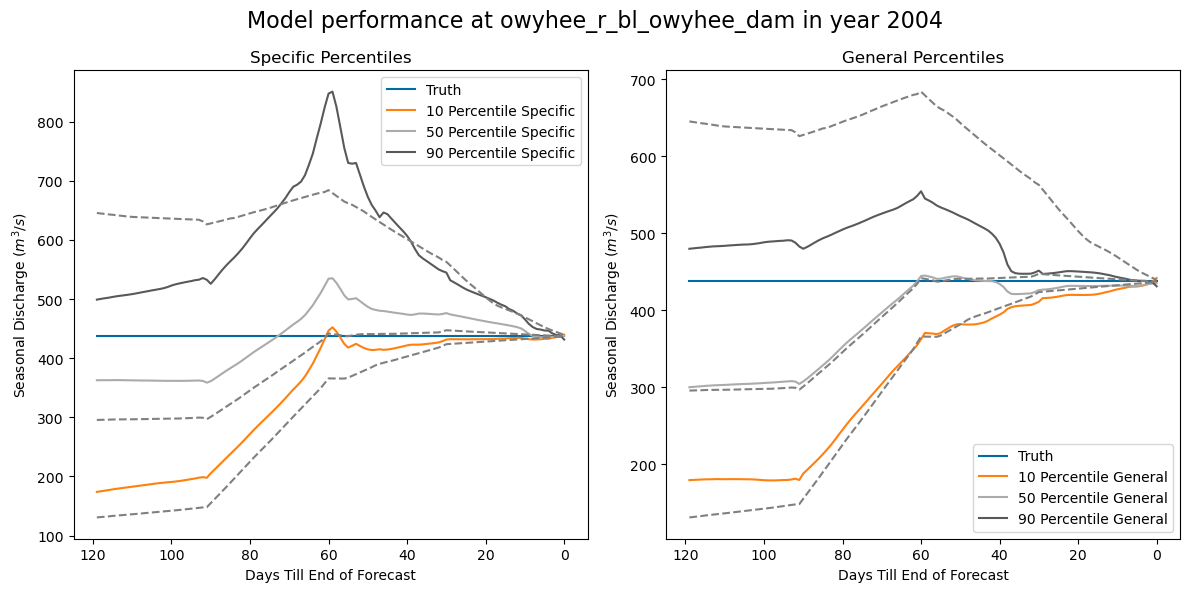

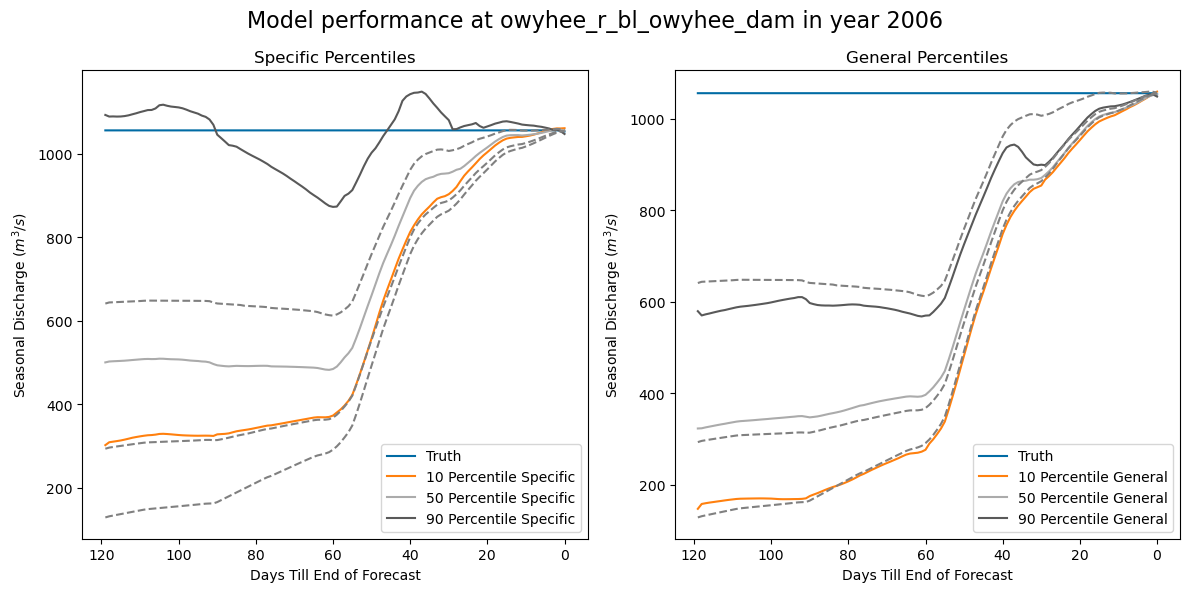

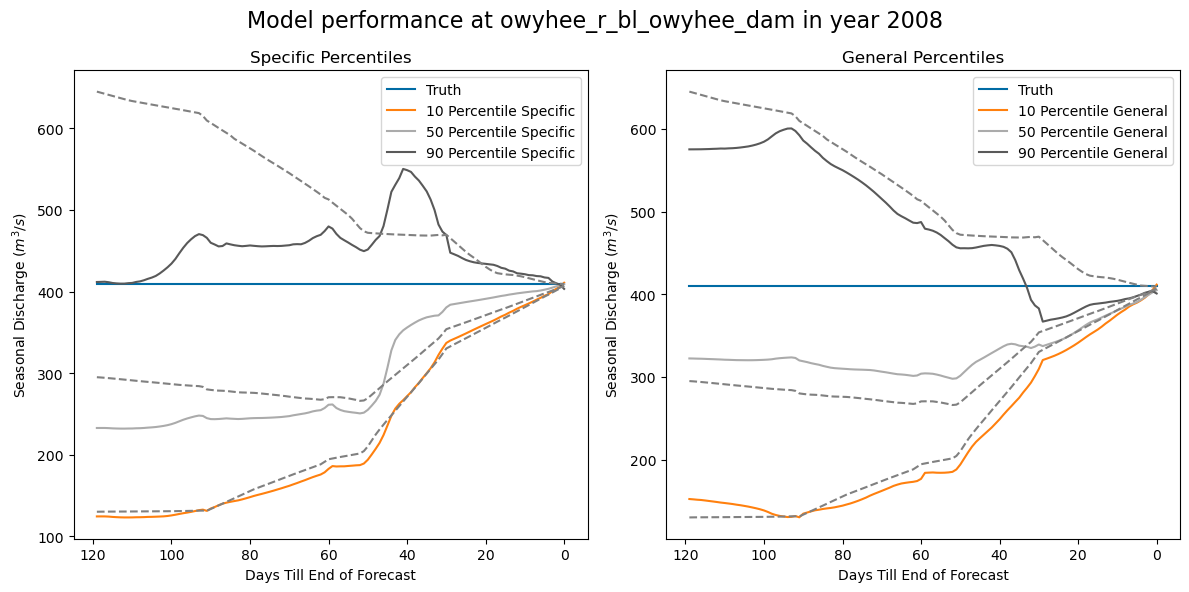

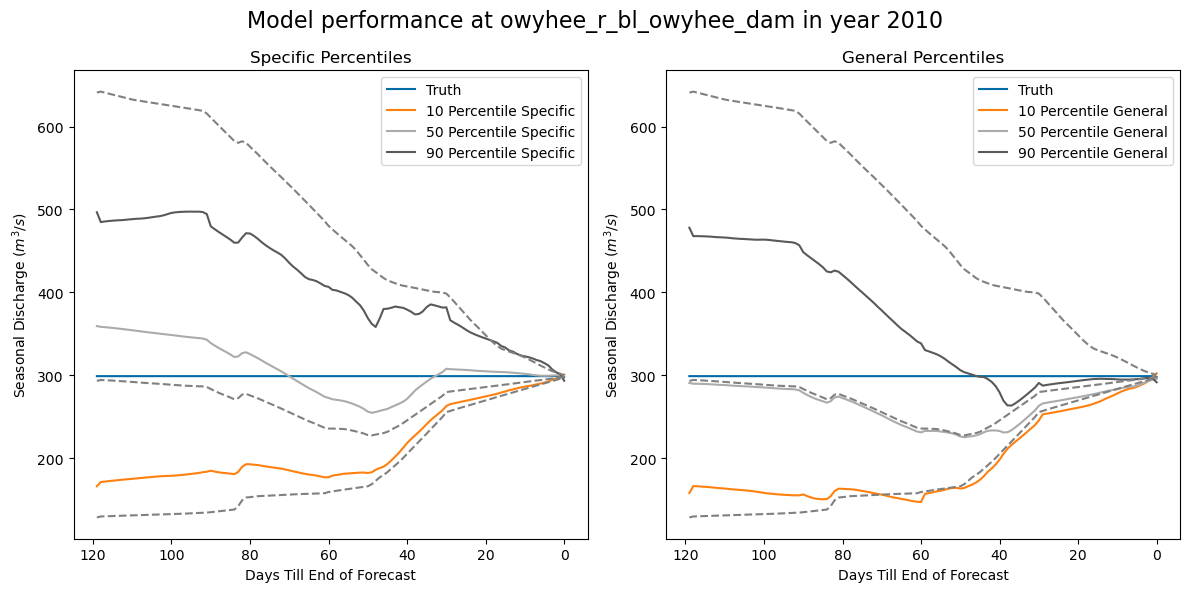

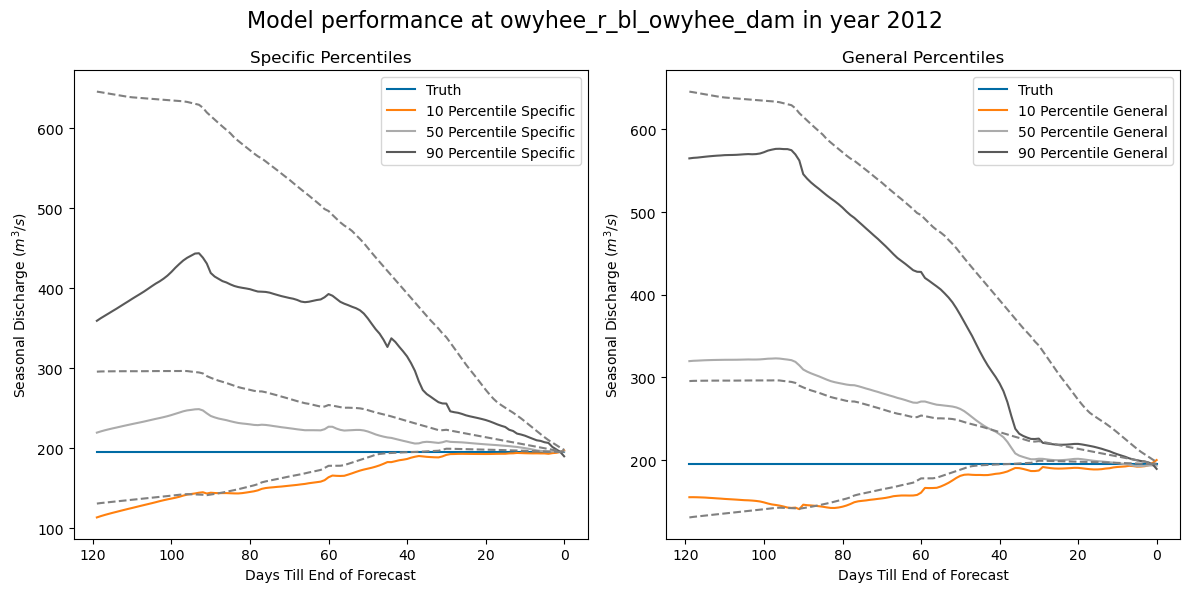

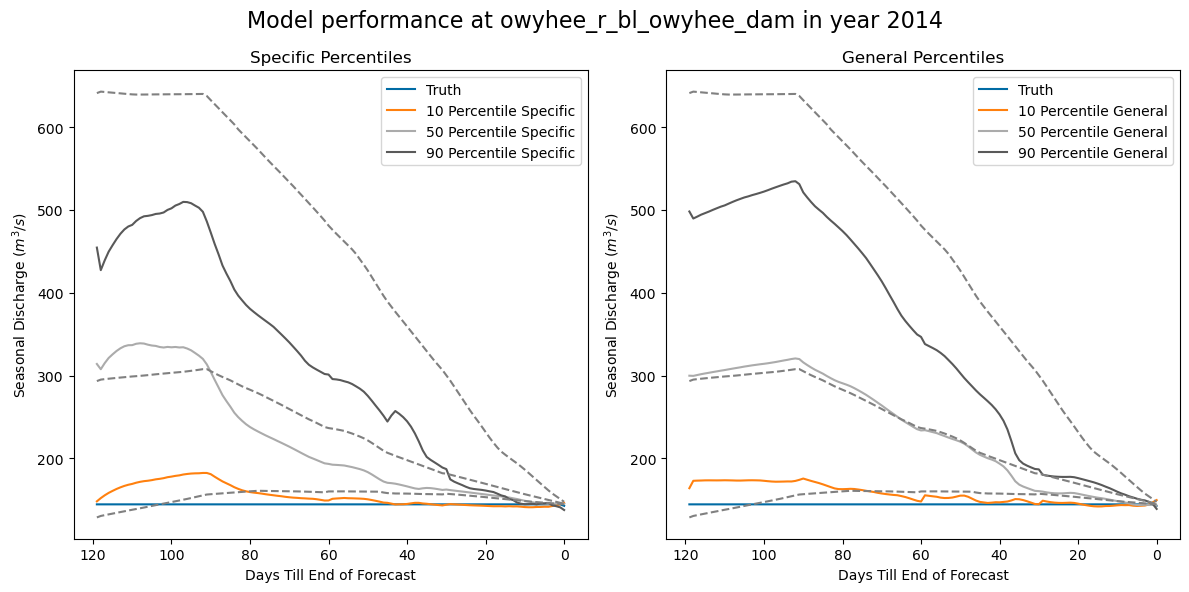

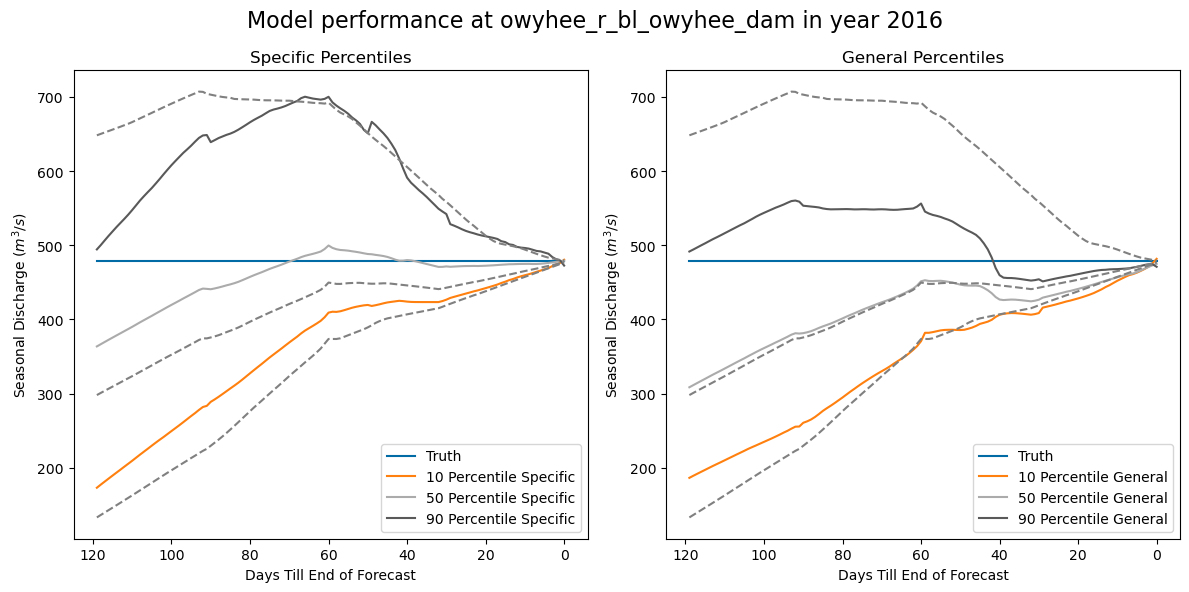

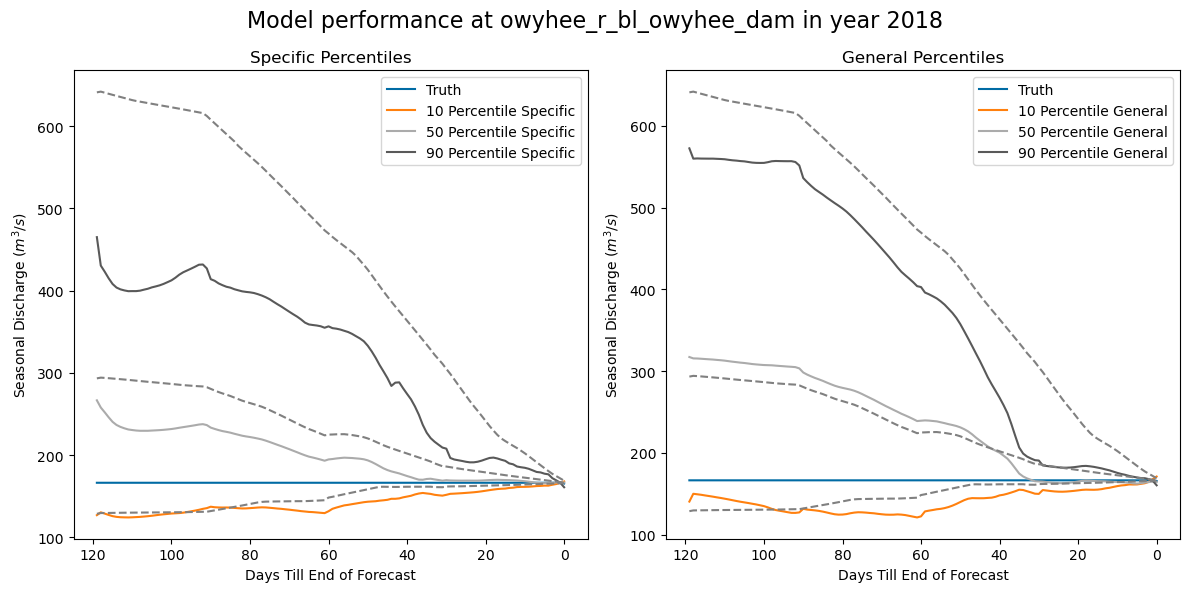

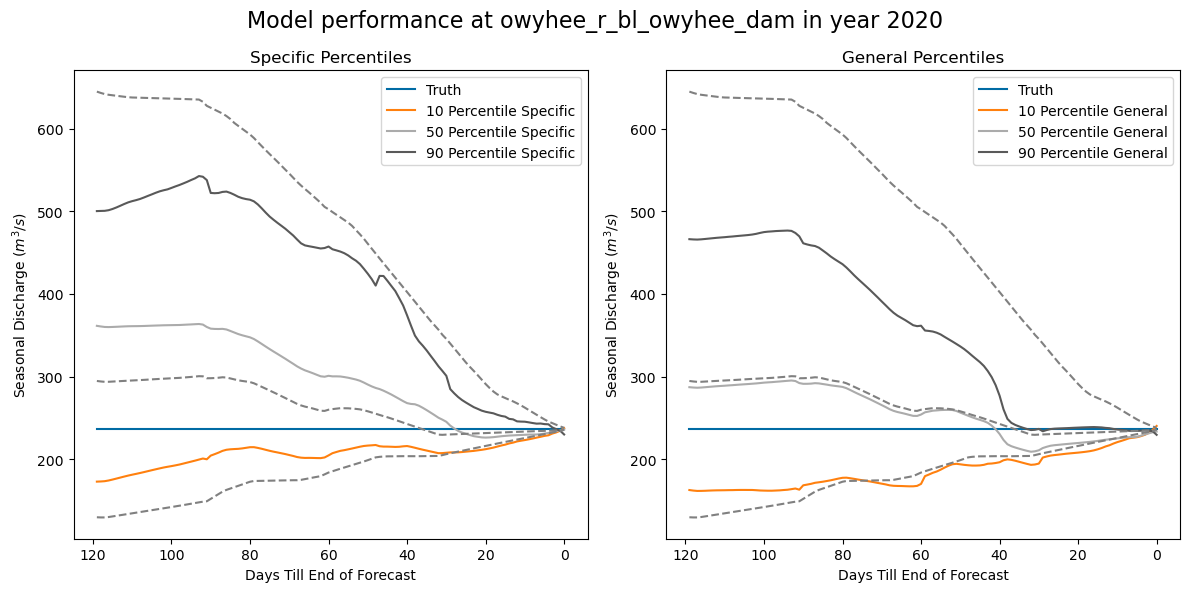

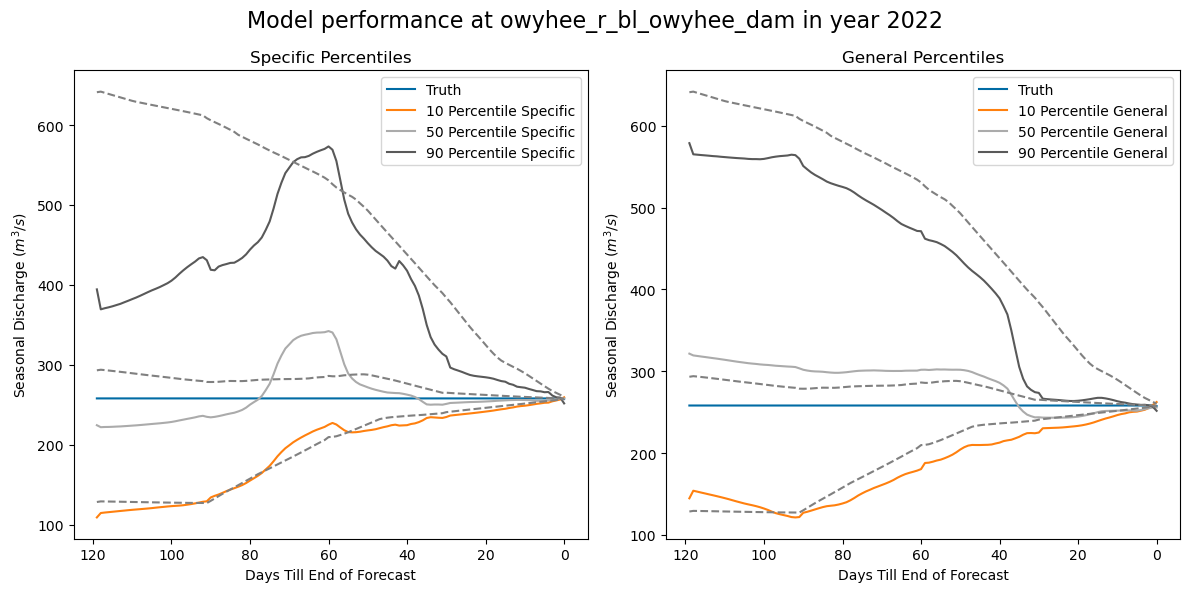

In [56]:
start_season_date = '2022-03-01'
end_season_date = '2022-05-31'
years = [2000,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020, 2022]
year = 2022
# daily_flow['owyhee']
# for basin in basins:
for year in years:
    start_season_date = f'{year}-02-01'
    end_season_date = f'{year}-05-31'

    basin = 'owyhee_r_bl_owyhee_dam'

    flow_scaler_filename = f'/data/gbmc/Rodeo_Submission/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
    flow_scaler = joblib.load(flow_scaler_filename) 

    #True_Flow  = test_performance_for_basin_and_season(basin, Hydra_Body, General_Hydra_Head, model_heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, Static_variables, device, end_season_date, start_season_date, flow_scaler, furthest_distance=120, feed_forcing= feed_forcing)


    Specific, General, Truth, Climatology_10, Climatology_50, Climatology_90  = test_performance_for_basin_and_season(basin, Hydra_Body, General_Hydra_Head, model_heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, Static_variables, device, end_season_date, start_season_date, flow_scaler, furthest_distance=120, feed_forcing= feed_forcing)


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for Specific
    No_Days = len(Specific[:, 0])
    Days_Til_Season = No_Days - np.arange(1, No_Days + 1)

    axes[0].plot(Truth, label='Truth')
    axes[0].plot(Days_Til_Season, Specific[:, 0], label='10 Percentile Specific')
    axes[0].plot(Days_Til_Season, Specific[:, 1], label='50 Percentile Specific')
    axes[0].plot(Days_Til_Season, Specific[:, 2], label='90 Percentile Specific')
    # axes[0].plot(Days_Til_Season, Climatology_10, label='10 Percentile Climatology')
    # axes[0].plot(Days_Til_Season, Climatology_50, label='50 Percentile Climatology')
    # axes[0].plot(Days_Til_Season, Climatology_90, label='90 Percentile Climatology')

    axes[0].legend()
    axes[0].set_title('Specific Percentiles')

    # Plot for General
    axes[1].plot(Truth, label='Truth')
    axes[1].plot(Days_Til_Season, General[:, 0], label='10 Percentile General')
    axes[1].plot(Days_Til_Season, General[:, 1], label='50 Percentile General')
    axes[1].plot(Days_Til_Season, General[:, 2], label='90 Percentile General')


    axes[1].legend()
    axes[1].set_title('General Percentiles')

    for ax in axes:
        ax.set_ylabel('Seasonal Discharge ($m^3/s$)')
        ax.invert_xaxis()
        ax.set_xlabel('Days Till End of Forecast')



    plt.suptitle(f'Model performance at {basin} in year {year}', fontsize=16)

    Clmiatology = True
    # Need to make code to get climatology of the season of interest
    if Clmiatology == True:
        # Add horizontal dashed lines for quantiles
        axes[0].plot(Days_Til_Season, Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
        axes[0].plot(Days_Til_Season, Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
        axes[0].plot(Days_Til_Season, Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')

        axes[1].plot(Days_Til_Season,Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
        axes[1].plot(Days_Til_Season,Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
        axes[1].plot(Days_Til_Season,Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')
        
    plt.tight_layout()
    plt.show()